In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Project1/InkData_word.zip" -d '/content/'

Streaming output truncated to the last 5000 lines.
 extracting: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_2.txt  
  inflating: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_3.png  
 extracting: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_3.txt  
  inflating: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_4.png  
 extracting: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_4.txt  
  inflating: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_5.png  
 extracting: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_5.txt  
  inflating: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_6.png  
 extracting: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_6.txt  
  inflating: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_7.png  
 extracting: /content/InkData_word_processed/20151209_0145_7276_2_tg_5_1_7.txt  
  inflating: /content/InkData_word_processed/20151209_0145

In [ ]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import glob
from matplotlib import pyplot as plt
# import fastwer
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
char_list = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789\
			 ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặ\
			 ẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ "
print(len(char_list))

205


In [ ]:
threshold = [32, 128]

In [ ]:
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [ ]:
def resize(img): 
    w, h = img.shape
    if (threshold[0]/w < threshold[1]/h):
        scale_percent = threshold[0]/w
    else:
        scale_percent = threshold[1]/h
    height = int(img.shape[0] * scale_percent)
    width = int(img.shape[1] * scale_percent)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    return img

In [ ]:
def reshape_expand_dim(img):
    w, h = img.shape
    if w < threshold[0]:
            add_zeros = np.ones((threshold[0]-w, h))*210
            img = np.concatenate((img, add_zeros))
    if h < threshold[1]:
        add_zeros = np.ones((threshold[0], threshold[1]-h))*210
        img = np.concatenate((img, add_zeros), axis=1)
    img = np.expand_dims(img , axis = 2)

    return img

In [ ]:
# Đọc file ảnh và text(ảnh và text để chung 1 file)
def read_data(path):
	Img = []
	Txt = []
	Input_length = []
	Label_length = []
	Labels = []
	max_label_len = 0

	files = glob.glob(path)
	for file in files:

		img = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY)   
		kernel = np.ones((5,5),np.uint8)
		img = cv2.erode(img,kernel,iterations = 2)
			
		# convert each image of shape ()
		img = resize(img)
		img = reshape_expand_dim(img)
		
		# Normalize each image
		img = img/255

		file_name = file.split('/')[-1]
		# print(file_name)
		file_name = file_name.split('.')[0]
		# print(file_name)

		# get the text from the image
		f = open('/content/InkData_word_processed/' + file_name + '.txt', "r", encoding="UTF-8")
		txt = f.read()
		# print(txt)
		f.close()
		# compute maximum length of the text
		if len(txt) > max_label_len:
				max_label_len = len(txt)
		Img.append(img)
		Txt.append(encode_to_labels(txt))  
		Input_length.append(16)
		Label_length.append(len(txt))
		Labels.append(txt) 

	Img = np.array(Img)
	Input_length = np.array(Input_length)
	Label_length = np.array(Label_length)
	# pad each output label to maximum text length
	Padded_txt = pad_sequences(Txt, maxlen = max_label_len, 
							   padding = 'post', value = len(char_list))
	return Img, Padded_txt, Input_length, Label_length, Labels, max_label_len

In [ ]:
path = '/content/InkData_word_processed/*.png'
Img, Padded_txt, Input_length, Label_length, Labels, max_label_len = read_data(path)

In [ ]:
print(Img.shape)
print(Labels[0])

(50000, 32, 128, 1)
việc


In [ ]:
train_img, valid_img,train_padded_txt, \
valid_padded_txt, train_input_length,\
valid_input_length, train_label_length, \
valid_label_length,train_Labels,\
valid_Labels = train_test_split(Img, Padded_txt, Input_length, 
												  Label_length, 
												  Labels,
												  test_size = 0.15, random_state = 0)

In [ ]:
def sque(x):
    return K.squeeze(x, axis = 1)

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [ ]:
from keras.layers import *
from tensorflow.keras import layers
inputs = Input(shape=(threshold[0], threshold[1],1))
    # First conv block
x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(inputs)
x = layers.MaxPooling2D((2, 2),strides = 2, name="pool1")(x)

    # Second conv block
x = layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
x = layers.MaxPooling2D((2, 2), strides = 2, name="pool2")(x)

    # Third conv block
x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
x = layers.MaxPooling2D((2, 2), name="pool3")(x)

    # Fourth conv block
x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv4",
    )(x)

x = layers.MaxPooling2D((2, 1), name="pool4")(x)

    # Fifth conv block
x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv5",
    )(x)

x = layers.BatchNormalization(momentum = 0.8, name="BatchNormalization_1")(x)
    

    # Sixth conv block
x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv6",
    )(x)

x = layers.BatchNormalization(momentum = 0.8, name="BatchNormalization_2")(x)

x = layers.MaxPooling2D((2, 1), name="pool6")(x)
squeezed = sque(x)
 
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25),
                        name = 'LSTM_1')(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25),
                        name='LSTM_2')(blstm_1)
 
outputs = Dense(len(char_list)+1, activation='softmax', name='fully_connected')(blstm_2)

act_model = Model(inputs, outputs)
act_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 32, 128, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 128, 64)       640       
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 64, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 16, 64, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 32, 128)        0         
                                                                 
 Conv3 (Conv2D)              (None, 8, 32, 256)        295168    
                                                                 
 pool3 (MaxPooling2D)        (None, 4, 16, 256)        0  

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

In [ ]:
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([outputs, labels, input_length, label_length])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model = Model(inputs=[inputs, labels, input_length, label_length], 
			  outputs=loss_out)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, 
			  optimizer=optimizer)

In [ ]:
batch_size = 64
epochs = 50
#------------------------------------------------
history = model.fit(x=[train_img, train_padded_txt, train_input_length, train_label_length],
					y=np.zeros(len(train_img)),
					batch_size=batch_size,
					epochs=epochs,
					validation_data=([valid_img, valid_padded_txt, valid_input_length, valid_label_length],
									 np.zeros(len(valid_img))),
					verbose=1)

Epoch 1/50
665/665 [==============================] - 89s 120ms/step - loss: 14.3447 - val_loss: 11.2074
Epoch 2/50
665/665 [==============================] - 73s 109ms/step - loss: 9.8393 - val_loss: 8.5585
Epoch 3/50
665/665 [==============================] - 73s 110ms/step - loss: 7.2884 - val_loss: 6.5246
Epoch 4/50
665/665 [==============================] - 77s 116ms/step - loss: 5.6811 - val_loss: 5.0707
Epoch 5/50
665/665 [==============================] - 74s 112ms/step - loss: 4.5818 - val_loss: 4.0950
Epoch 6/50
665/665 [==============================] - 72s 108ms/step - loss: 3.7843 - val_loss: 3.5698
Epoch 7/50
665/665 [==============================] - 71s 106ms/step - loss: 3.1868 - val_loss: 3.0323
Epoch 8/50
665/665 [==============================] - 73s 110ms/step - loss: 2.6991 - val_loss: 2.8100
Epoch 9/50
665/665 [==============================] - 76s 115ms/step - loss: 2.3257 - val_loss: 2.8069
Epoch 10/50
665/665 [==============================] - 70s 105ms/step -

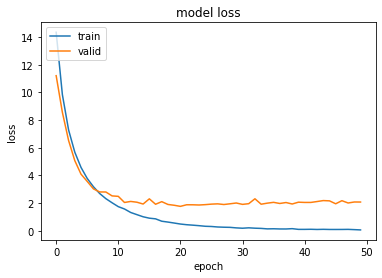

In [ ]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
#act_model.save('./save/best_model_ver8.hdf5')

In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):

    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
  
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
 
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [ ]:
import tensorflow.keras.backend as K
# index = 6
for index in range(10):
    print(valid_img[index].shape)
    prediction = act_model.predict(valid_img[index][None, :, :, :])
    # plt.imshow(valid_img[index])
    out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                                greedy=True)[0][0])
    predicted_str = ''
    for x in (out):
        for p in x:  
            if int(p) != -1:
                predicted_str += char_list[int(p)]

    print(predicted_str)



(32, 128, 1)
1/1 [==============================] - 0s 19ms/step
ngày
(32, 128, 1)
1/1 [==============================] - 0s 19ms/step
bị
(32, 128, 1)
1/1 [==============================] - 0s 35ms/step
công
(32, 128, 1)
1/1 [==============================] - 0s 20ms/step
bao
(32, 128, 1)
1/1 [==============================] - 0s 19ms/step
trưng
(32, 128, 1)
1/1 [==============================] - 0s 20ms/step
được
(32, 128, 1)
1/1 [==============================] - 0s 23ms/step
khoan
(32, 128, 1)
1/1 [==============================] - 0s 19ms/step
1
(32, 128, 1)
1/1 [==============================] - 0s 19ms/step
bị
(32, 128, 1)
1/1 [==============================] - 0s 23ms/step
Tám


In [ ]:
y_true = valid_Labels
correct_char = 0
total_char = 0
correct = 0
total = 0
test_wer, test_cer = [], []
for index in range(len(valid_img)):
    prediction = act_model.predict(valid_img[index][None, :, :, :])
    out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                                greedy=True)[0][0])
    predicted_str = ''
    for x in (out):
        for p in x:  
            if int(p) != -1:
                predicted_str += char_list[int(p)]
    print(predicted_str)
    if predicted_str == y_true[index]:
        correct += 1
        correct_char += len(y_true[index])
    total += 1
    total_char += len(y_true[index])
    test_wer.append(wer(y_true[index], predicted_str))
    test_cer.append(cer(y_true[index], predicted_str))

avg_cer = sum(test_cer)/len(test_cer)
avg_wer = sum(test_wer)/len(test_wer)
print('Average CER: %.2f%%' % (avg_cer*100))
print('Average WER: %.2f%%' % (avg_wer*100))
print('Character Accuracy: %.2f%%' % (correct_char/total_char*100))
print('Word Accuracy: %.2f%%' % (correct/total*100))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
Phú
1/1 [==============================] - 1s 767ms/step
không
1/1 [==============================] - 0s 190ms/step
cậu
1/1 [==============================] - 0s 32ms/step
vột
1/1 [==============================] - 0s 27ms/step
NiNn
1/1 [==============================] - 1s 574ms/step
rừng
1/1 [==============================] - 0s 31ms/step
lúc
1/1 [==============================] - 0s 22ms/step
tục
1/1 [==============================] - 0s 27ms/step
Như
1/1 [==============================] - 0s 30ms/step
nhng
1/1 [==============================] - 0s 23ms/step
an
1/1 [==============================] - 1s 597ms/step
cùng
1/1 [==============================] - 0s 30ms/step
sao
1/1 [==============================] - 0s 23ms/step
ran
1/1 [==============================] - 0s 23ms/step
đá
1/1 [==============================] - 0s 25ms/step
hặn
1/1 [==============================] - 1s 585

In [ ]:
def resize_(img): 
    w, h = img.shape
    if (32/w < 128/h):
        scale_percent = 32/w
    else:
        scale_percent = 128/h
    height = int(img.shape[0] * scale_percent)
    width = int(img.shape[1] * scale_percent)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    return img
    
def reshape_expand_dim_(img):
    w, h = img.shape
    if w < 32:
            add_zeros = np.ones((32-w, h))*210
            img = np.concatenate((img, add_zeros))
    if h < 128:
        add_zeros = np.ones((32, 128-h))*210
        img = np.concatenate((img, add_zeros), axis=1)
    img = np.expand_dims(img , axis = 2)
    print(img.shape)

    return img
def read_data_(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5,5),np.uint8)
    img = cv2.erode(img,kernel,iterations = 2)
    img = resize_(img)
    img = reshape_expand_dim_(img)
    img = img/255.
    img = np.array(img)

    return img

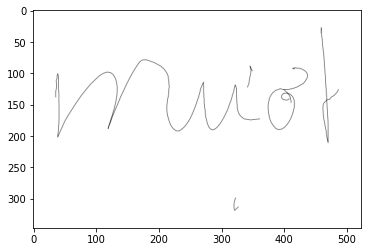

In [ ]:
img_ = cv2.imread('/content/InkData_word_processed/20140921_0021_5498_1_tg_1_1_10.png')
plt.imshow(img_)


In [ ]:
with open('/content/InkData_word_processed/20140921_0021_5498_1_tg_1_1_10.txt') as f:
    lines = f.readlines()
    print(lines)

['mượt']


In [ ]:
def predict(img):
    img = read_data_(img)
#     print(img.shape)
    #plt.imshow(img)
    img = img[None, :, :, :]
#     print(img.shape)
    prediction = act_model.predict(img)
    
    out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                             greedy=True)[0][0])
    predicted_str = ''
    for x in (out):
        for p in x:  
            if int(p) != -1:
                predicted_str += char_list[int(p)]    
    # print(len(predicted_str) )
    return predicted_str

a = predict(img_)
a

(32, 128, 1)
1/1 [==============================] - 0s 24ms/step


'mượt'

In [ ]:
act_model.save('./model_v3.h5')

In [ ]:
from tensorflow.keras.models import Model, load_model
model = load_model("./model_v3.h5")

In [ ]:
import tensorflow.keras.backend as K
index = 1
for index in range(10):
    prediction = model.predict(valid_img[index][None, :, :, :])
    #plt.imshow(valid_img[index])
    out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                                greedy=True)[0][0])
    predicted_str = ''
    for x in (out):
        for p in x:  
            if int(p) != -1:
                predicted_str += char_list[int(p)]

    print(predicted_str)

1/1 [==============================] - 2s 2s/step
ngày
1/1 [==============================] - 0s 20ms/step
bị
1/1 [==============================] - 0s 23ms/step
công
1/1 [==============================] - 0s 20ms/step
bao
1/1 [==============================] - 0s 20ms/step
trưng
1/1 [==============================] - 0s 20ms/step
được
1/1 [==============================] - 0s 26ms/step
khoan
1/1 [==============================] - 0s 21ms/step
1
1/1 [==============================] - 0s 23ms/step
bị
1/1 [==============================] - 0s 23ms/step
Tám
